In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import gensim
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("nlp_train.csv")
df.head()

,id,keyword,location,text,target
0,1707,bridge%20collapse,NaN,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
1,5789,hail,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
2,7789,police,Houston,CNN: Tennessee movie theater shooting suspect ...,1
3,8257,rioting,NaN,Still rioting in a couple of hours left until ...,1
4,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0


In [ ]:
dataset = pd.DataFrame({'Text':df['text'],'Target':df['target']})
dataset.head()

,Text,Target
0,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
1,GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
2,CNN: Tennessee movie theater shooting suspect ...,1
3,Still rioting in a couple of hours left until ...,1
4,Crack in the path where I wiped out this morni...,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    5329 non-null   object
 1   Target  5329 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 83.4+ KB


In [ ]:
# build train and test datasets
text = dataset['Text'].values
labels = dataset['Target'].values

train_text = text[:3500]
train_labels = labels[:3500]

test_text = text[3500:]
test_labels = labels[3500:]

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def remove_http(url):
  p= re.compile('(http(s)?|www)')
  url = p.sub('',url)
  return url

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip() 
    doc = remove_http(doc) 
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_text)
norm_test_reviews = pre_process_corpus(test_text)

100%|██████████| 1829/1829 [00:00<00:00, 6936.03it/s]

CPU times: user 910 ms, sys: 69.8 ms, total: 980 ms
Wall time: 1 s


In [ ]:
%%time
import nltk
from gensim.models import word2vec

tokenized_corpus = [nltk.word_tokenize(doc) for doc in norm_train_reviews]

# Set values for various parameters
feature_size = 300  # Word vector dimensionality  
window_context = 20  # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3        # Downsample setting for frequent words
sg = 1               # skip-gram model

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sg=sg, sample=sample, iter=50)
w2v_model

CPU times: user 1min 16s, sys: 208 ms, total: 1min 17s
Wall time: 42.1 s


In [ ]:
words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]


In [ ]:
vec_df = pd.DataFrame(wvs, index=words)
vec_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
the,0.241211,0.341420,-0.201116,-0.124777,-0.119304,0.263904,-0.504923,0.187308,0.394538,0.166305,-0.132605,-0.147001,0.330089,-0.065269,-0.012627,0.059536,0.212947,-0.418822,-0.086423,0.231558,0.491325,0.325723,-0.446809,0.111106,0.142558,0.044997,-0.497702,-0.274721,0.273057,0.209277,-0.401507,-0.202642,0.267459,-0.258491,0.236724,0.451364,-0.077067,-0.050666,0.273630,0.018966,...,-0.364670,-0.067426,0.027686,0.316294,-0.164947,0.044370,0.309283,0.510315,0.071284,0.070713,-0.728280,-0.144712,-0.114638,-0.115534,-0.070863,-0.255768,-0.152346,-0.018869,0.015506,0.149773,0.139489,0.161576,0.500882,-0.140015,-0.001178,0.257821,-0.513860,-0.120993,-0.190547,0.031359,-0.166411,0.186999,0.196679,0.175014,-0.361612,0.021223,-0.342805,0.084497,-0.025188,0.138068
a,-0.297615,-0.143610,0.511525,-0.366993,0.785940,-0.058451,0.225120,0.414584,-0.440682,-0.190860,-0.557826,-0.700950,0.346081,-0.385920,0.092538,0.330962,-0.278183,0.543220,0.028741,-0.244918,0.475989,-0.061011,-0.543947,0.112066,-0.510707,-0.286973,0.385790,-0.448511,-0.086173,0.013783,0.249211,-0.476166,0.192149,-0.342168,-0.022976,-0.078643,-0.348463,0.358421,0.576964,0.201551,...,-0.040011,0.291093,0.478292,-0.392846,-0.415202,0.058254,0.113628,0.291557,0.594006,-0.179513,-0.473190,-0.202305,0.042238,0.408447,0.227200,-0.144925,-0.192673,0.136824,0.158309,-0.282164,-0.140320,-0.147015,0.112027,0.140398,0.272904,0.182517,0.646625,0.001499,0.502228,0.117924,-0.099239,0.055801,0.590141,-0.207380,0.305435,-0.036510,-0.682413,-0.007092,-0.330199,-0.016032
in,0.593587,-0.379053,0.467009,0.753108,0.817780,0.114286,-0.107665,0.511395,0.433462,0.123273,-0.756462,-0.004567,-0.166184,-0.245916,0.564116,-0.230555,0.121086,-0.088334,0.171940,-0.180833,0.603962,0.479037,0.032262,0.342554,0.135765,-0.793085,0.069929,-0.024300,-0.338665,0.214190,0.284018,0.157316,-0.082361,0.388682,0.088115,0.155177,-0.026272,-0.179187,-0.110996,-0.109351,...,-0.131979,0.882969,-0.399496,-0.088852,0.388622,0.399100,-0.414610,0.299848,0.888695,0.294801,-0.264537,0.066976,-0.065597,-0.226475,-0.175515,0.351232,0.221606,-0.668620,0.021267,-0.212122,-0.317535,-0.333093,-0.400549,0.361422,-0.369083,0.369375,-0.123182,0.002252,0.355645,0.095631,0.306398,0.218424,0.619392,0.597010,-0.155804,0.136644,0.211899,0.339946,0.274070,0.196595
to,0.293386,0.077718,0.228181,-0.124411,0.328801,-0.149709,-0.179677,-0.188506,-0.170886,0.016026,-0.298535,-0.233926,0.248572,-0.681330,0.029615,-0.480681,-0.149154,0.238971,0.054905,-0.164056,-0.374052,0.273127,-0.396981,0.158359,-0.295988,-0.043789,0.057198,-0.197457,-0.440142,0.006019,-0.116109,-0.233337,-0.127170,0.315221,-0.455181,-0.407916,0.213170,-0.147281,-0.330855,0.391630,...,-0.063177,0.030295,-0.181714,-0.244878,-0.446458,-0.715380,-0.067303,0.224521,-0.320644,-0.523251,-0.377481,0.304757,-0.248688,0.182642,-0.298782,0.340497,-0.070838,0.266983,0.058820,0.514863,0.056081,-0.376858,-0.447205,-0.338184,-0.029066,0.450055,0.371257,0.213376,-0.249732,-0.169844,-0.304595,-0.216151,0.389611,0.040588,0.488215,-0.031321,-0.300108,-0.376899,-0.684744,0.390444
of,0.090366,-0.286259,-0.283668,-0.332942,0.231795,0.062451,0.269737,0.288740,-0.101312,-0.075474,-0.427807,-0.535328,0.190256,-0.020584,-0.025124,-0.272400,-0.082024,-0.103739,0.204625,0.081424,0.055034,-0.265564,-0.304862,0.072713,0.543210,-0.034519,-0.097419,0.308725,0.095434,0.295598,-0.061749,-0.221191,0.322116,0.526905,0.415751,0.382268,-0.278234,0.015829,0.267735,0.216774,...,-0.070553,-0.473393,0.489541,-0.017340,-0.367661,0.519066,-0.335975,0.376080,0.565824,-0.158951,-0.032415,-0.508855,-0.354857,-0.190526,0.094856,0.147677,-0.028122,-0.092822,-0.132736,0.049660,0.141632,0.234105,0.568727,0.252489,-0.156464,0.302168,-0.404920,-0.317935,-0.0

In [ ]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    print(vocabulary)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        #print(feature_vector)
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
               # print(feature_vector)
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
norm_train_reviews[0]

'ashes 2015 australiauas collapse at trent bridge among worst in history england bundled out australia for 60 tcot5trhjuau0'

In [ ]:
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=norm_train_reviews[0], model=w2v_model,
                                                     num_features=feature_size)

Streaming output truncated to the last 5000 lines.
 -4.67341065e-01 -2.36051962e-01 -5.73293447e-01 -7.12483376e-02
  1.01077981e-01 -5.03714919e-01 -2.48837993e-01  1.91116054e-02
 -9.92651954e-02  6.20860636e-01 -1.52377293e-01 -5.77748656e-01
  4.79271822e-02  2.18229756e-01 -3.92266810e-01  1.16613284e-01
  1.10894598e-01 -1.21815167e-01 -3.17709953e-01  9.66807157e-02
  1.78485379e-01  1.31953126e-02  5.98481484e-02 -2.18468785e-01
 -1.12845331e-01 -4.40137655e-01  2.25288924e-02 -4.59200181e-02
  2.85774589e-01 -1.05676383e-01 -4.90974039e-01 -1.38043374e-01
 -2.12207913e-01 -2.35334694e-01 -4.09599155e-01 -2.80542910e-01
  4.86618787e-01  5.28523326e-01  4.00505275e-01 -9.23977420e-02
  1.85168654e-01 -3.58662665e-01 -4.95885491e-01 -3.85386616e-01
 -5.61904192e-01  2.44164035e-01 -2.08199978e-01  1.56129405e-01
 -2.76777416e-01  1.68940052e-01  1.44108802e-01  2.88736612e-01
 -2.23338768e-01  1.49641663e-01 -3.28575104e-01 -4.22116630e-02
  6.29912317e-02  4.14175987e-02 -3.815

In [ ]:
avg_wv_train_features.shape

(122, 300)

In [ ]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=norm_train_reviews, model=w2v_model,
                                                     num_features=feature_size)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=norm_test_reviews, model=w2v_model,
                                                    num_features=feature_size)

In [ ]:

print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)

Word2Vec model:> Train features shape: (3500, 300)  Test features shape: (1829, 300)


In [ ]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, input_shape=(num_input_features,)))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(512))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(256))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(1))
    dnn_model.add(Activation('sigmoid'))

    dnn_model.compile(loss='binary_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [ ]:
w2v_dnn = construct_deepnn_architecture(num_input_features=feature_size)

In [ ]:

w2v_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               154112    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [ ]:
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, train_labels, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
32/32 [==============================] - 1s 15ms/step - loss: 0.6842 - accuracy: 0.5613 - val_loss: 0.6799 - val_accuracy: 0.5657
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.6707 - accuracy: 0.5883 - val_loss: 0.6824 - val_accuracy: 0.5629
Epoch 3/10
32/32 [==============================] - 0s 11ms/step - loss: 0.6585 - accuracy: 0.6095 - val_loss: 0.6642 - val_accuracy: 0.6000
Epoch 4/10
32/32 [==============================] - 0s 10ms/step - loss: 0.6464 - accuracy: 0.6102 - val_loss: 0.6799 - val_accuracy: 0.6171
Epoch 5/10
32/32 [==============================] - 0s 11ms/step - loss: 0.6437 - accuracy: 0.6213 - val_loss: 0.6509 - val_accuracy: 0.6029
Epoch 6/10
32/32 [==============================] - 0s 10ms/step - loss: 0.6332 - accuracy: 0.6298 - val_loss: 0.6487 - val_accuracy: 0.6086
Epoch 7/10
32/32 [==============================] - 0s 11ms/step - loss: 0.6366 - accuracy: 0.6298 - val_loss: 0.6521 - val_accuracy: 0.6314
Epoch 8/10
32

In [ ]:
dnn_prediction = w2v_dnn.predict_classes(avg_wv_test_features)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
labels = ['negative', 'positive']
print(classification_report(test_labels, dnn_prediction))
pd.DataFrame(confusion_matrix(test_labels, dnn_prediction), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.69      0.62      0.65      1023
           1       0.57      0.65      0.61       806

    accuracy                           0.63      1829
   macro avg       0.63      0.63      0.63      1829
weighted avg       0.64      0.63      0.63      1829



,negative,positive
negative,630,393
positive,286,520


**CNN**

In [ ]:

t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('tcog5zsru0zvq', 13043), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=13044
Number of Documents=3500


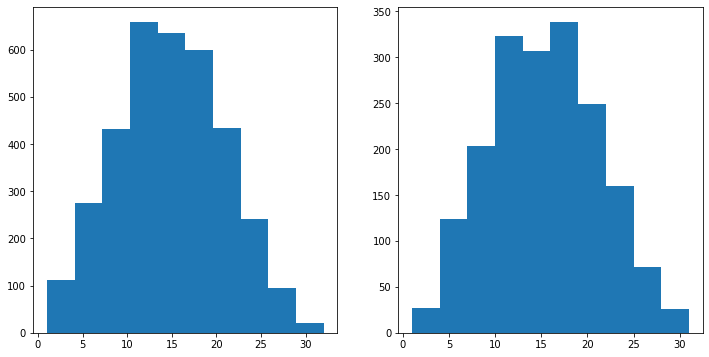

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:

MAX_SEQUENCE_LENGTH = 40

In [ ]:

# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((3500, 40), (1829, 40))

In [ ]:

VOCAB_SIZE = len(t.word_index)

In [ ]:
EMBED_SIZE = 300
EPOCHS=10
BATCH_SIZE=128

In [ ]:

# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           3913200   
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 128)           153728    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 64)            32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 32)            8224      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 32)            

In [ ]:

# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

# Fit the model
model.fit(X_train, train_labels, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          callbacks=[es], 
          verbose=1)

Epoch 1/10
25/25 [==============================] - 5s 157ms/step - loss: 0.6794 - accuracy: 0.5683 - val_loss: 0.6346 - val_accuracy: 0.5800
Epoch 2/10
25/25 [==============================] - 4s 145ms/step - loss: 0.4169 - accuracy: 0.8298 - val_loss: 0.4854 - val_accuracy: 0.7971
Epoch 3/10
25/25 [==============================] - 4s 144ms/step - loss: 0.1195 - accuracy: 0.9632 - val_loss: 0.6368 - val_accuracy: 0.7714
Epoch 4/10
25/25 [==============================] - 4s 145ms/step - loss: 0.0439 - accuracy: 0.9873 - val_loss: 0.8825 - val_accuracy: 0.7857
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, test_labels, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

58/58 [==============================] - 0s 8ms/step - loss: 0.5227 - accuracy: 0.7687
Accuracy: 76.87%


In [ ]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
labels = ['negative', 'positive']
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.78      0.81      0.80      1023
           1       0.75      0.72      0.73       806

    accuracy                           0.77      1829
   macro avg       0.77      0.76      0.76      1829
weighted avg       0.77      0.77      0.77      1829



,negative,positive
negative,827,196
positive,227,579
